## 範例重點
* 學習如何在 keras 中加入 model checkpoint
* 知道如何設定監控目標
* 比較使用最佳與非最佳參數時的 performance

In [1]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 5
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [8]:
"""
# 載入 Callbacks, 並將監控目標設為 validation loss, 且只存最佳參數時的模型
"""
from keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="./D86/BestWeights.h5", save_weights_only=True,
                             monitor="val_loss", verbose=1,
                             save_best_only=False)

In [9]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
model.save('./D86/my_empty_model.h5') 

optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
model.save('./D86/my_complied_model.h5') 



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512 

In [10]:
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )


Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 13s 266us/step - loss: 2.2034 - accuracy: 0.2711 - val_loss: 2.1136 - val_accuracy: 0.2366

Epoch 00001: saving model to ./D86/BestWeights.h5
Epoch 2/5
50000/50000 [==============================] - 12s 238us/step - loss: 1.7373 - accuracy: 0.3928 - val_loss: 1.9704 - val_accuracy: 0.2863

Epoch 00002: saving model to ./D86/BestWeights.h5
Epoch 3/5
50000/50000 [==============================] - 12s 236us/step - loss: 1.6124 - accuracy: 0.4344 - val_loss: 1.8171 - val_accuracy: 0.3586

Epoch 00003: saving model to ./D86/BestWeights.h5
Epoch 4/5
50000/50000 [==============================] - 14s 272us/step - loss: 1.5393 - accuracy: 0.4626 - val_loss: 1.7167 - val_accuracy: 0.4018

Epoch 00004: saving model to ./D86/BestWeights.h5
Epoch 5/5
50000/50000 [==============================] - 13s 252us/step - loss: 1.4872 - accuracy: 0.4816 - val_loss: 1.6565 - val_accuracy: 0.4129

Epoc

In [11]:
# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

In [12]:
model.save('./D86/my_fitted_model.h5') 

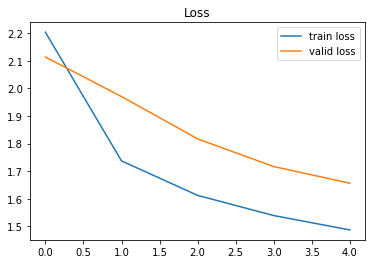

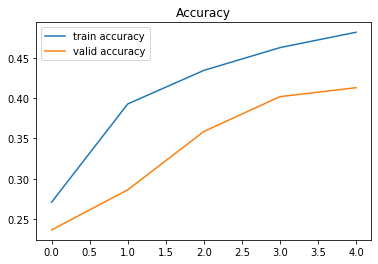

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
#plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
#plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

In [14]:
# ReLoad and Run x_test
from keras.models import load_model

del model
model.load_weights("./D86/BestWeights.h5")


NameError: name 'model' is not defined

In [19]:
# ReLoad NON-COMPLIED and Run x_test
from keras.models import load_model

model = load_model('./D86/my_empty_model.h5')
model.load_weights("./D86/BestWeights.h5")

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [20]:
# Run x_test
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
print(loss_loadback, acc_loadback)

RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.

In [21]:
# ReLoad COMPLIED MODEL + WEIGHTS and Run x_test
del model
model = load_model('./D86/my_complied_model.h5')
model.load_weights("./D86/BestWeights.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
print(loss_loadback, acc_loadback)

10000/10000 [==============================] - 3s 336us/step
1.6565223323822023 0.41290000081062317


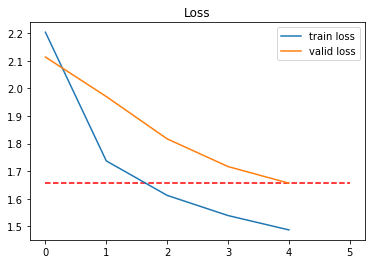

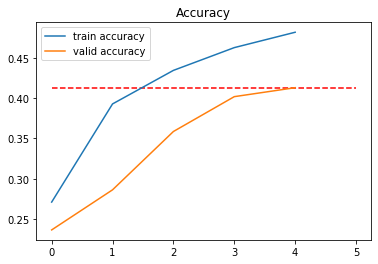

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

In [23]:
# ReLoad FITTED MODEL and Run x_test
del model
model = load_model('./D86/my_fitted_model.h5')
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
print(loss_loadback, acc_loadback)

10000/10000 [==============================] - ETA:  - 2s 247us/step
1.6565223323822023 0.41290000081062317


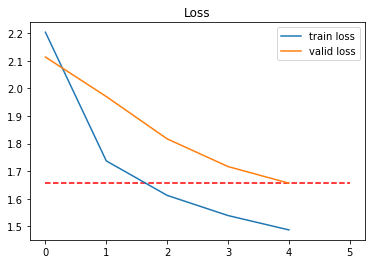

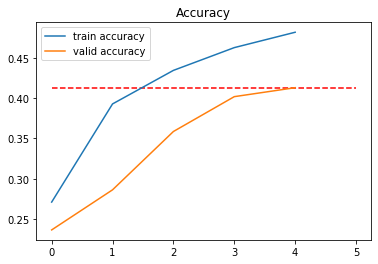

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test